# Westside Apartments
> This notebook fetches Los Angeles apartment listings from Westside Rentals and assigns their official neighborhoods, allowing for more detailed analysis of available units in specific areas. 

---

#### Import Python tools and Jupyter config

In [1]:
import requests
import pandas as pd
import jupyter_black
import altair as alt
import geopandas as gpd

In [2]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

---

## Fetch

#### Pull listings from rough Los Angeles city coordinates

In [3]:
headers = {
    "accept": "application/json, text/plain, */*",
    "accept-language": "en-US,en;q=0.9,es;q=0.8",
    "origin": "https://www.westsiderentals.com",
    "priority": "u=1, i",
    "referer": "https://www.westsiderentals.com/",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36",
}

#### Make the request

In [4]:
# Parameters
params = {
    "secretShake": "Master08!",
    "priceLow": "0",
    "priceHigh": "0",
    "leaseTypeList": "0",
    "propTypeList": "12,13,7,10",
    "bedTypeList": "0",
    "bathTypeList": "0",
    "petsList": "0",
    "furnList": "0",
    "showShort": "OK",
    "memberID": "0",
    "version": "v2",
}

# Coordinates as a raw string to prevent URL-encoding of the plus signs
coordinates = "POLYGON((-118.668404+34.337306,+-118.155289+34.337306,+-118.155289+33.703652,+-118.668404+33.703652,+-118.668404+34.337306))"

# Manually construct the URL by appending the manually formatted coordinates to the rest of the parameters
base_url = "https://jsonapi.westsiderentals.com/rest/search/listings/map"
url = f"{base_url}?coordinates={coordinates}"

# Make the request by passing the rest of the parameters through the `params` argument
response = requests.get(url, headers=headers, params=params)

#### Get dictionary from response with listings

In [5]:
data = response.json()["DATA"]

#### Convert the dictionary to a DataFrame

In [6]:
df = pd.DataFrame(data).query("PRICE_FROM > 0 and PRICE_FROM < 5000")
df.columns = df.columns.str.lower()

#### Dates

In [7]:
df["avail_date"] = pd.to_datetime(df["avail_date"], errors="coerce")
df["list_date"] = pd.to_datetime(df.get("list_date"), errors="coerce")

In [8]:
df.head()

,property_id,street_number,street_name,lat,lon,area_id,zipcode,property_type_id,avail_date,price_from,bedroomcount,bathroomcount,listing_id,bedroom_type_id,bathroom_type_id,orig_photo_url,pet_type_id,lease_type_id,furnished_type_id,list_date,featured,accessible,refrigerator,stove,microwave,dishwasher,yard,balcony,patio,controlled_access,air_conditioner,central_air,central_heat,fireplace,wd_hookups,wd,spa,elevator,quiet,pool_on_site,wallheater,listing_type_id,laundry,parking_type_id,flooring_type_id,landlord_phone,landlord_name,landlord_email,gender,cleanliness,photo_url,createdby,price_to,adpackage,city,property_name,unit_nbr,certified_freshness_date,isleaseapplicationenabled,adpackage_sort_ord,matterport_3d_key,isfeaturedrentalunit,hardwood,listing_key,contact_preference
1,1079586,13801,Paramount Blvd,33.91013,-118.16102,176,90723,40,NaT,2799.0,2,2.0,3182890,2,3,https://images1.apartments.com/i2/9MY8jKbIy_BlhuO4LnVhobuKAqtrF6e5NEdtTXWS_wE/111/image.jpg,13,4,1,2024-08-14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,None,2,False,1,41,(562) 667-4566,Kaylee Cardey,Enclave.Apartmentscom.GreystarRE@aptleasing.info,None,None,None,None,,4,Paramount,Enclave,,"August, 14 2024 00:00:00",False,14,AqY6jJsUS6G,False,False,z7n3bwz,Phone and Email
2,1079586,13801,Paramount Blvd,33.91013,-118.16102,176,90723,40,2023-03-31,2799.0,2,2.0,3182891,2,3,https://images1.apartments.com/i2/9MY8jKbIy_BlhuO4LnVhobuKAqtrF6e5NEdtTXWS_wE/111/image.jpg,13,4,1,2024-08-14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,None,2,False,1,41,(562) 667-4566,Kaylee Cardey,Enclave.Apartmentscom.GreystarRE@aptleasing.info,None,None,None,None,,4,Paramount,Enclave,,"August, 14 2024 00:00:00",False,14,AqY6jJsUS6G,False,False,z7n3bwz,Phone and Email
3,1079586,13801,Paramount Blvd,33.91013,-118.16102,176,90723,40,2024-08-02,2799.0,2,2.0,3182892,2,3,https://images1.apartments.com/i2/9MY8jKbIy_BlhuO4LnVhobuKAqtrF6e5NEdtTXWS_wE/111/image.jpg,13,4,1,2024-08-14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,None,2,False,1,41,(562) 667-4566,Kaylee Cardey,Enclave.Apartmentscom.GreystarRE@aptleasing.info,None,None,None,None,,4,Paramount,Enclave,,"August, 14 2024 00:00:00",False,14,AqY6jJsUS6G,False,False,z7n3bwz,Phone and Email
4,1079586,13801,Paramount Blvd,33.91013,-118.16102,176,90723,40,2023-03-31,2271.0,1,1.0,3182893,1,1,https://images1.apartments.com/i2/9MY8jKbIy_BlhuO4LnVhobuKAqtrF6e5NEdtTXWS_wE/111/image.jpg,13,4,1,2024-08-14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,None,2,False,1,41,(562) 667-4566,Kaylee Cardey,Enclave.Apartmentscom.GreystarRE@aptleasing.info,None,None,None,None,,4,Paramount,Enclave,,"August, 14 2024 00:00:00",False,14,AqY6jJsUS6G,False,False,z7n3bwz,Phone and Email
5,1079586,13801,Paramount Blvd,33.91013,-118.16102,176,90723,40,NaT,2271.0,1,1.0,3182894,1,1,https://images1.apartments.com/i2/9MY8jKbIy_BlhuO4LnVhobuKAqtrF6e5NEdtTXWS_wE/111/image.jpg,13,4,1,2024-08-14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,None,2,False,1,41,(562) 667-4566,Kaylee Cardey,Enclave.Apartmentscom.GreystarRE@aptleasing.info,None,None,None,None,,4,Paramount,Enclave,,"August, 14 2024 00:00:00",False,14,AqY6jJsUS6G,False,False,z7n3bwz,Phone and Email


---

## Geography

#### LA County cities, neighborhoods

In [9]:
la_hoods_gdf = gpd.read_file(
    "https://stilesdata.com/la/la_city_hoods_county_munis.geojson"
)

<Axes: >

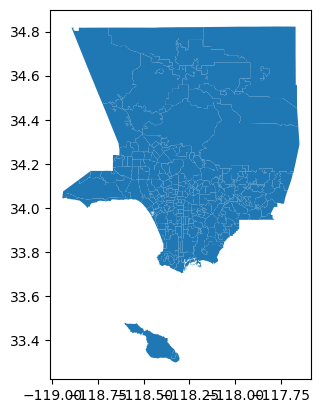

In [10]:
la_hoods_gdf.plot()

#### Put our listings into a geodataframe using coordinates

In [11]:
listings_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

<Axes: >

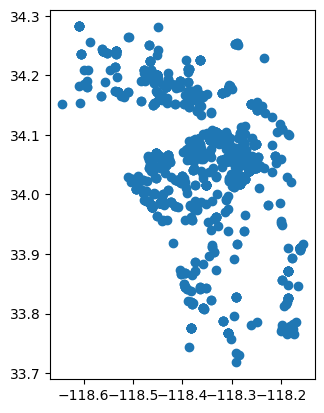

In [12]:
listings_gdf.plot()

#### Assign neighborhoods to listings

In [13]:
listings_hoods_gdf = gpd.sjoin(listings_gdf, la_hoods_gdf)

In [14]:
westside_listings_gdf = listings_hoods_gdf.query('region == "westside"')

#### How many

In [15]:
len(westside_listings_gdf)

279

#### Mean price

In [16]:
westside_listings_gdf["price_from"].mean()

3136.032258064516

In [19]:
westside_listings_gdf.groupby(["name", "bedroomcount"]).agg(
    {"price_from": "median"}
).round().reset_index().query("bedroomcount == 1").sort_values(
    "price_from"
).reset_index(
    drop=True
)

,name,bedroomcount,price_from
0,Mar Vista,1,2500.0
1,Westwood,1,2575.0
2,Santa Monica,1,2600.0
3,Culver City,1,2698.0
4,Beverly Hills,1,2750.0
5,Cheviot Hills,1,2820.0
6,Palms,1,2865.0
7,Marina del Rey,1,2952.0
8,Venice,1,3040.0
9,West Los Angeles,1,3148.0
